In [1]:
import pandas as pd
import os
import sklearn
from sklearn import datasets
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,392 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,552 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-u

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

# Set the partitions to 4 or 8.
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [3]:
# import raw github csv and show df

from pyspark import SparkFiles
url ="https://raw.githubusercontent.com/melissaa06/Four_Real_Productions/main/Movie_Data_Set_Project_4.csv"
spark.sparkContext.addFile(url)
movies_df = spark.read.csv(SparkFiles.get("Movie_Data_Set_Project_4.csv"), header=True, inferSchema=True)
movies_df.show()


+--------------------+-------------+------------+---------------+--------+----------------+------------------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|          Budget|           Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+----------------+------------------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|$250,000,000.00 |  $835,000,000.00 |    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| $90,000,000.00 |  $369,105,725.00 |    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|               -|    $4,495,365.00 |    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| $12,000,000.00 |  $158,000,000.00 |    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|               -|                 -|    105|
|Detective Knight:...|            R|     1/20/23

In [4]:
#Import function
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace, col

#Change - to 0 in the reveunue column
update_func = (F.when(F.col('revenue') == '-', '0')
                .otherwise(F.col('revenue')))
movies_df = movies_df.withColumn('Revenue', update_func)

# Remove the dollar sign from the 'revenue' column
movies_df = movies_df.withColumn("Revenue", regexp_replace(col("Revenue"), "\\$", ""))

# Remove the comma from the 'revenue' column
movies_df = movies_df.withColumn("Revenue", regexp_replace(col("Revenue"), ",", ""))

#Change - to 0 in the budget column
update_func = (F.when(F.col('Budget') == '-', '0')
                .otherwise(F.col('Budget')))
movies_df = movies_df.withColumn('Budget', update_func)

# Remove the dollar sign from the 'budget' column
movies_df = movies_df.withColumn("Budget", regexp_replace(col("Budget"), "\\$", ""))

# Remove the comma from the 'budgt' column
movies_df = movies_df.withColumn("Budget", regexp_replace(col("Budget"), ",", ""))
movies_df.show()

+--------------------+-------------+------------+---------------+--------+-------------+--------------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|       Budget|       Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+-------------+--------------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000.00 | 835000000.00 |    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000.00 | 369105725.00 |    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|            0|   4495365.00 |    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000.00 | 158000000.00 |    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|            0|             0|    105|
|Detective Knight:...|            R|     1/20/23|         Action| English|            0|             0| 

In [5]:

#Update dtypes to number
movies_df = movies_df.withColumn("Revenue", col("Revenue").cast("long"))
movies_df = movies_df.withColumn("Budget", col("Budget").cast("long"))
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|        0|   4495365|    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|        0|         0|    105|
|Detective Knight:...|            R|     1/20/23|         Action| English|        0|         0|     92|
|              JUNG_E|         PG13|     1/20/23|Science Fiction

In [6]:
#Change NULL values in Budget to 0
movies_df = movies_df.na.fill(0)
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|        0|   4495365|    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|        0|         0|    105|
|Detective Knight:...|            R|     1/20/23|         Action| English|        0|         0|     92|
|              JUNG_E|         PG13|     1/20/23|Science Fiction

In [7]:
# Add a new column 'profit' that is the difference between 'revenue' and 'budget'
movies_df = movies_df.withColumn("Profit", col("Revenue") - col("Budget"))
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+----------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|    Profit|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+----------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162| 585000000|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103| 279105725|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|        0|   4495365|    101|   4495365|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102| 146000000|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|        0|         0|    105|         0|
|Detective Knight:...|            R|     1/20/23|         Action| English|      

In [8]:
# Create a temporary view of the DataFrame.

movies_df.createOrReplaceTempView('movies')

In [9]:
# Find Profit by genres overall years
spark.sql("""
select genres,
sum(profit) as total_profit
from movies
group by genres
order by total_profit desc
""").show()

+---------------+------------+
|         genres|total_profit|
+---------------+------------+
|         Action| 84833849486|
|      Adventure| 60000121674|
|      Animation| 33028431478|
|         Comedy| 30438145548|
|          Drama| 26345448385|
|Science Fiction| 16093725241|
|        Fantasy| 16045530697|
|         Horror| 15854383746|
|         Family| 14633375209|
|       Thriller|  8014757472|
|          Crime|  6331547007|
|        Romance|  4423323847|
|            War|  2508345266|
|        Mystery|  2051751973|
|          Music|  1955487385|
|        History|  1002590294|
|        Western|   623043231|
|    Documentary|     7699990|
|       TV Movie|           0|
+---------------+------------+



In [10]:
# Find Profit by genres by year
spark.sql("""
select genres,
sum(profit) as total_profit,
right(Release_Date,2) as year
from movies
group by genres, year
order by total_profit desc
""").show()

+---------+------------+----+
|   genres|total_profit|year|
+---------+------------+----+
|   Action|  9105315811|  18|
|   Action|  7480282205|  17|
|   Action|  7449445611|  15|
|   Action|  6722626032|  16|
|Adventure|  6359087425|  19|
|   Action|  5492619215|  14|
|   Action|  4750340727|  09|
|   Action|  4090253064|  12|
|   Action|  3953754591|  13|
|Animation|  3801984804|  13|
|Adventure|  3637432888|  17|
|   Action|  3631690392|  19|
|Adventure|  3505185969|  05|
|   Action|  3352483754|  21|
|    Drama|  3123684762|  12|
|Adventure|  2864193659|  10|
|   Action|  2861483972|  22|
|Adventure|  2807699990|  03|
|   Family|  2806838689|  19|
|    Drama|  2704928105|  17|
+---------+------------+----+
only showing top 20 rows



In [11]:
movies_pd_df = movies_df.toPandas()
movies_pd_df.head()

,Movie_Name,Certification,Release_Date,Genres,Language,Budget,Revenue,Runtime,Profit
0,Black Panther: Wakanda Forever,PG13,11/10/22,Action,English,250000000,835000000,162,585000000
1,Puss in Boots: The Last Wish,PG,12/8/22,Animation,English,90000000,369105725,103,279105725
2,Shotgun Wedding,R,12/28/22,Action,English,0,4495365,101,4495365
3,M3GAN,PG13,1/5/23,Science Fiction,English,12000000,158000000,102,146000000
4,Transfusion,MA15+,1/5/23,Crime,English,0,0,105,0


Mean Squared Error: 1.6684410398979888e+16


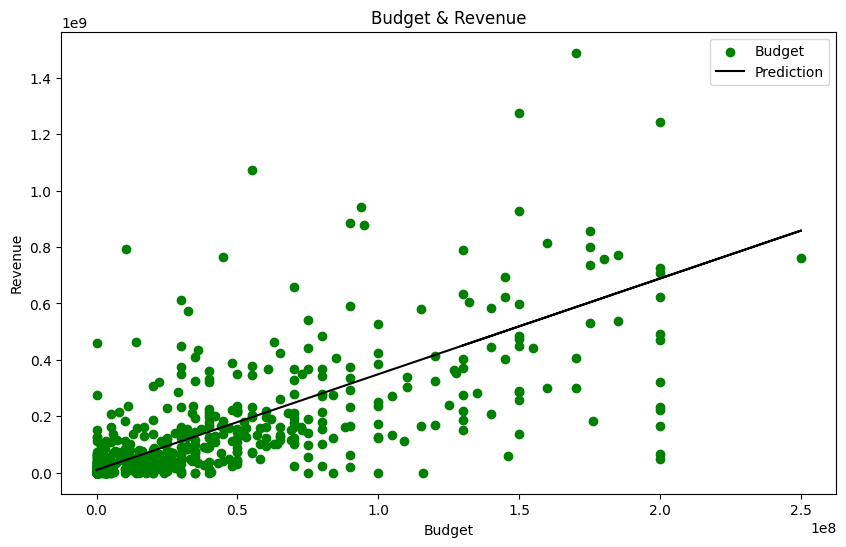

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Drop rows with missing values
movies_pd_df = movies_pd_df.dropna(subset=['Revenue', 'Budget'])

# Targets
X = movies_pd_df[['Budget']]
y = movies_pd_df['Revenue']

# Split and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Mean squared
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='green', label='Budget')
plt.plot(X_test, y_pred, color='black', label='Prediction')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Budget & Revenue')
plt.legend()
plt.show()

Mean Squared Error: 912.1734537764142


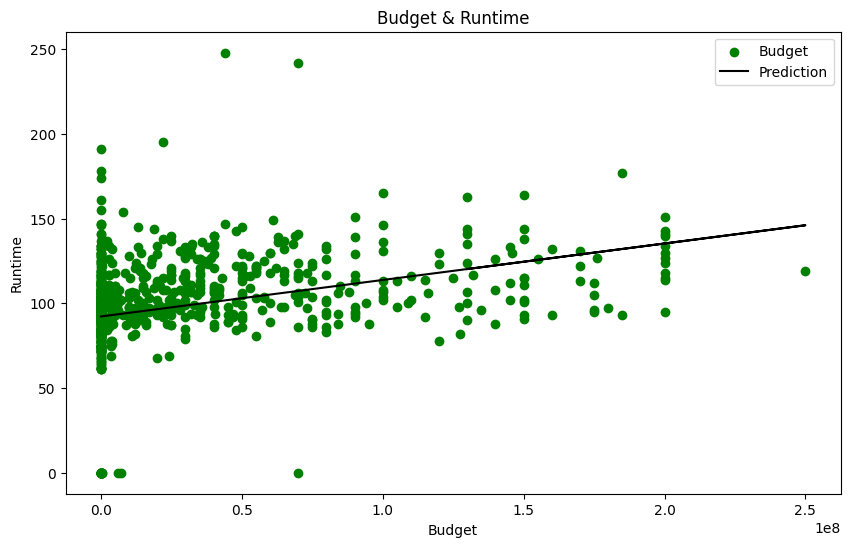

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Drop rows with missing values
movies_pd_df = movies_pd_df.dropna(subset=['Runtime', 'Budget'])

# Targets
X = movies_pd_df[['Budget']]
y = movies_pd_df['Runtime']

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='green', label='Budget')
plt.plot(X_test, y_pred, color='black', label='Prediction')
plt.xlabel('Budget')
plt.ylabel('Runtime')
plt.title('Budget & Runtime')
plt.legend()
plt.show()

Mean Squared Error: 1.668441039897991e+16


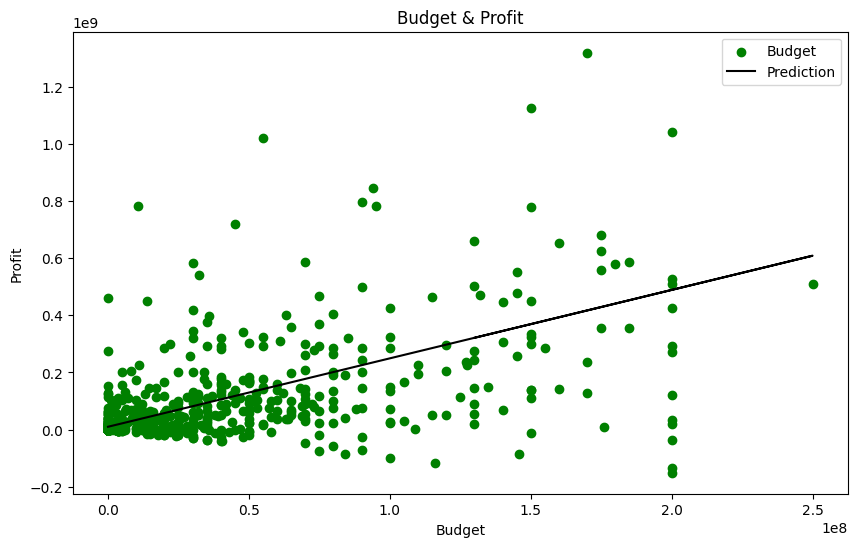

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Drop rows with missing values
movies_pd_df = movies_pd_df.dropna(subset=['Profit', 'Budget'])

# Targets
X = movies_pd_df[['Budget']]
y = movies_pd_df['Profit']

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Mean squared
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='green', label='Budget')
plt.plot(X_test, y_pred, color='black', label='Prediction')
plt.xlabel('Budget')
plt.ylabel('Profit')
plt.title('Budget & Profit')
plt.legend()
plt.show()

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Categorical columns for one-hot encoding
categorical_cols = ['Certification', 'Genres']

# OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)  # 'ignore' handles unknown categories during prediction

#  Transform the categorical columns
encoded_data = encoder.fit_transform(movies_pd_df[categorical_cols])

# DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded features with the original DataFrame
movies_pd_df_encoded = pd.concat([movies_pd_df, encoded_df], axis=1)

# Drop old columns
movies_pd_df_encoded = movies_pd_df_encoded.drop(categorical_cols, axis=1)

# Display the first few rows of the encoded DataFrame
print(movies_pd_df_encoded.head())

                       Movie_Name Release_Date Language     Budget    Revenue  \
0  Black Panther: Wakanda Forever     11/10/22  English  250000000  835000000   
1    Puss in Boots: The Last Wish      12/8/22  English   90000000  369105725   
2                 Shotgun Wedding     12/28/22  English          0    4495365   
3                           M3GAN       1/5/23  English   12000000  158000000   
4                     Transfusion       1/5/23  English          0          0   

   Runtime     Profit  Certification_-  Certification_0  Certification_10  \
0      162  585000000              0.0              0.0               0.0   
1      103  279105725              0.0              0.0               0.0   
2      101    4495365              0.0              0.0               0.0   
3      102  146000000              0.0              0.0               0.0   
4      105          0              0.0              0.0               0.0   

   ...  Genres_History  Genres_Horror  Genres_Musi

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
movies_pd_df_encoded.head()

,Movie_Name,Release_Date,Language,Budget,Revenue,Runtime,Profit,Certification_-,Certification_0,Certification_10,...,Genres_History,Genres_Horror,Genres_Music,Genres_Mystery,Genres_Romance,Genres_Science Fiction,Genres_TV Movie,Genres_Thriller,Genres_War,Genres_Western
0,Black Panther: Wakanda Forever,11/10/22,English,250000000,835000000,162,585000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Puss in Boots: The Last Wish,12/8/22,English,90000000,369105725,103,279105725,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Shotgun Wedding,12/28/22,English,0,4495365,101,4495365,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M3GAN,1/5/23,English,12000000,158000000,102,146000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Transfusion,1/5/23,English,0,0,105,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
movies_pd_df_encoded.columns

Index(['Movie_Name', 'Release_Date', 'Language', 'Budget', 'Revenue',
       'Runtime', 'Profit', 'Certification_-', 'Certification_0',
       'Certification_10',
       ...
       'Genres_History', 'Genres_Horror', 'Genres_Music', 'Genres_Mystery',
       'Genres_Romance', 'Genres_Science Fiction', 'Genres_TV Movie',
       'Genres_Thriller', 'Genres_War', 'Genres_Western'],
      dtype='object', length=110)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

  -150989359       0.00      0.00      0.00         1
  -133200000       0.00      0.00      0.00         1
  -116000000       0.00      0.00      0.00         1
   -99928524       0.00      0.00      0.00         1
   -86900000       0.00      0.00      0.00         1
   -84000000       0.00      0.00      0.00         1
   -75000000       0.00      0.00      0.00         1
   -70000000       0.00      0.00      0.00         1
   -55788809       0.00      0.00      0.00         1
   -46840695       0.00      0.00      0.00         1
   -40000000       0.00      0.00      0.00         1
   -38317508       0.00      0.00      0.00         1
   -35000000       0.00      0.00      0.00         2
   -34839995       0.00      0.00      0.00         1
   -30000000       0.00      0.00      0.00         2
   -26720000       0.00      0.00      0.00         1
   -26476717       0.00      0.00      0.00         1
   -25580000       0.00    

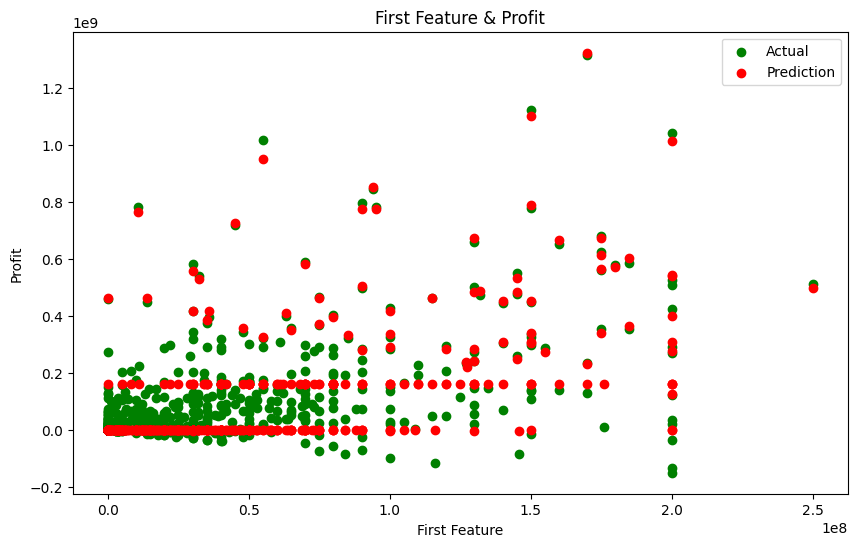

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np # Import numpy

# Assuming 'movies_pd_df_encoded' is your DataFrame and 'Profit' is your target
# Select all numerical columns as features
X = movies_pd_df_encoded.select_dtypes(include=[np.number]).drop('Profit', axis=1)  # Drop 'Profit'
y = movies_pd_df_encoded['Profit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a SVM model
model = SVC()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot the results (example - you might need to adjust based on your data)
plt.figure(figsize=(10, 6))
plt.scatter(X_test.iloc[:, 0], y_test, color='green', label='Actual')
plt.scatter(X_test.iloc[:, 0], y_pred, color='red', label='Prediction')
plt.xlabel('First Feature')
plt.ylabel('Profit')
plt.title('First Feature & Profit')
plt.legend()
plt.show()

In [19]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [31]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
# Drop the non-beneficial columns
movies_pd_df_encoded = movies_pd_df_encoded.drop(['Movie_Name','Release_Date','Language'], axis=1)
movies_pd_df_encoded.head()

KeyError: "['Movie_Name', 'Release_Date', 'Language'] not found in axis"

In [22]:
# Split our preprocessed data into our features and target arrays
X = movies_pd_df_encoded.drop("Profit", axis=1).values
y = movies_pd_df_encoded["Profit"].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [23]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
def create_model(hp):
    nn = tf.keras.models.Sequential()

# Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
# First hidden layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=X_train_scaled.shape[1]))
        # step=2), activation=activation, input_dim=2))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn

In [25]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [26]:
tuner.search(x=X_train_scaled, y=y_train, epochs=20, validation_data=(X_test_scaled,y_test), batch_size=32)


Trial 60 Complete [00h 00m 13s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 06m 13s


In [29]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'sigmoid',
 'first_units': 1,
 'num_layers': 4,
 'units_0': 3,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0,
 'units_1': 1,
 'units_2': 1,
 'units_3': 1}

In [30]:
# Evaluate the model using the test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

20/20 - 0s - loss: -2.7257e+07 - accuracy: 0.0000e+00 - 452ms/epoch - 23ms/step
Loss: -27257190.0, Accuracy: 0.0
